# Hyperparameter Tuning Using Feature Set 1

---

**Feature Set 1** includes:

- **Soil Moisture**
- **Temperature**
- **Soil Humidity**
- **Air Humidity (%)**

The dataset used for this analysis is available [here](https://www.kaggle.com/datasets/nelakurthisudheer/dataset-for-predicting-watering-the-plants).

## Importing Libraries

Import necessary libraries and do basic set up

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    auc
)

# For handling warnings
import warnings
warnings.filterwarnings('ignore')

## Data Preparation and Feature Selection

1. **Import Dataset and Preprocess Data**: Load `soil_data.csv`, select required columns, drop nulls, and encode `Status`.
2. **Feature Selection**: Define features as `Soil Moisture`, `Temperature`, `Soil Humidity`, and `Air humidity (%)`.
3. **Select Features and Targets**: Assign features to `X` and target `Status` to `y`.


In [68]:
#import dataset, choose required columns, drop nulls and encode status
df = pd.read_csv('soil_data.csv')
required_columns = ['Soil Moisture', 'Temperature' , 'Soil Humidity', 'Air humidity (%)', 'Status']
df_clean = df.dropna(subset=required_columns)
df_clean['Status'] = df_clean['Status'].map({'OFF': 0, 'ON': 1})

#choose features
feature_set_1 = ['Soil Moisture', 'Temperature', 'Soil Humidity', 'Air humidity (%)']

# select features and targets
X = df_clean[feature_set_1]
y = df_clean['Status']




4. **Splitting Data**: The dataset is split into 70% training and 30% evaluation sets.**Select Features and Targets**: Assign features to `X` and target `Status` to `y`.

In [69]:
#splitting data into 70% training and 30% evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Evaluation set size: {X_test.shape[0]} samples")

Training set size: 16796 samples
Evaluation set size: 7199 samples


## Logistic Regression


### Tuning Hyperparameters


In [70]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, loguniform

# Define a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Define parameter distributions with additional hyperparameters
param_distributions = [
    {
        'logreg__penalty': ['l1'],
        'logreg__solver': ['liblinear', 'saga'],
        'logreg__C': loguniform(1e-4, 1e4),
        'logreg__class_weight': [None, 'balanced'],
        'logreg__fit_intercept': [True, False],
        'logreg__tol': uniform(1e-5, 1e-3),
        'logreg__max_iter': [100, 200, 500, 1000],
        'logreg__multi_class': ['auto']
    },
    {
        'logreg__penalty': ['l2'],
        'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
        'logreg__C': loguniform(1e-4, 1e4),
        'logreg__class_weight': [None, 'balanced'],
        'logreg__fit_intercept': [True, False],
        'logreg__dual': [False],  # dual=True is only for 'liblinear' with 'l2'
        'logreg__tol': uniform(1e-5, 1e-3),
        'logreg__max_iter': [100, 200, 500, 1000],
        'logreg__multi_class': ['auto', 'ovr', 'multinomial']
    },
    {
        'logreg__penalty': ['elasticnet'],
        'logreg__solver': ['saga'],
        'logreg__C': loguniform(1e-4, 1e4),
        'logreg__l1_ratio': [0.25, 0.5, 0.75],
        'logreg__class_weight': [None, 'balanced'],
        'logreg__fit_intercept': [True, False],
        'logreg__tol': uniform(1e-5, 1e-3),
        'logreg__max_iter': [100, 200, 500, 1000],
        'logreg__multi_class': ['auto', 'ovr', 'multinomial']
    },
    {
        'logreg__penalty': ['none'],
        'logreg__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'logreg__class_weight': [None, 'balanced'],
        'logreg__fit_intercept': [True, False],
        'logreg__tol': uniform(1e-5, 1e-3),
        'logreg__max_iter': [100, 200, 500, 1000],
        'logreg__multi_class': ['auto', 'ovr', 'multinomial']
    }
]

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=200,  # Number of parameter settings sampled
    scoring='precision',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best model
logreg = random_search.best_estimator_

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Precision Score: {random_search.best_score_:.4f}")


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Parameters: {'logreg__C': np.float64(0.0004817229581912984), 'logreg__class_weight': None, 'logreg__dual': False, 'logreg__fit_intercept': False, 'logreg__max_iter': 100, 'logreg__multi_class': 'multinomial', 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': np.float64(0.00031993692626861096)}
Best Precision Score: 0.7386


### Training Evaluations

In [71]:
# make predictions on training set
y_train_pred_logreg = logreg.predict(X_train)

# calculate training evaluation metrics
train_accuracy_logreg = accuracy_score(y_train, y_train_pred_logreg)
train_precision_logreg = precision_score(y_train, y_train_pred_logreg)
train_recall_logreg = recall_score(y_train, y_train_pred_logreg)
train_f1_logreg = f1_score(y_train, y_train_pred_logreg)

# display training metrics
print("Logistic Regression Training Performance Metrics:")
print(f"Accuracy : {train_accuracy_logreg:.4f}")
print(f"Precision: {train_precision_logreg:.4f}")
print(f"Recall   : {train_recall_logreg:.4f}")
print(f"F1-Score : {train_f1_logreg:.4f}")

Logistic Regression Training Performance Metrics:
Accuracy : 0.6964
Precision: 0.7374
Recall   : 0.6809
F1-Score : 0.7080


### Evaluation - Accuracy, Precision, Recall and F1-Score

In [72]:
# make predictions on test set, then predict on ROC Curve
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]

# calculate evaluation metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

# display metrics
print("Logistic Regression Performance Metrics:")
print(f"Accuracy : {accuracy_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}")
print(f"Recall   : {recall_logreg:.4f}")
print(f"F1-Score : {f1_logreg:.4f}")


Logistic Regression Performance Metrics:
Accuracy : 0.6869
Precision: 0.7301
Recall   : 0.6678
F1-Score : 0.6975


### Confusion Matrix

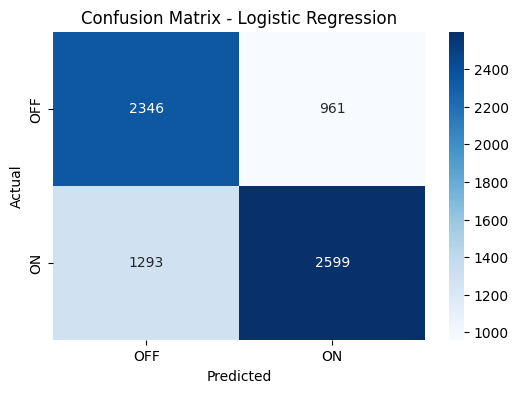

In [73]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['OFF', 'ON'], yticklabels=['OFF', 'ON'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


### Classification Reports

In [74]:
print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_logreg, target_names=['OFF', 'ON']))


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

         OFF       0.64      0.71      0.68      3307
          ON       0.73      0.67      0.70      3892

    accuracy                           0.69      7199
   macro avg       0.69      0.69      0.69      7199
weighted avg       0.69      0.69      0.69      7199



### ROC Curve

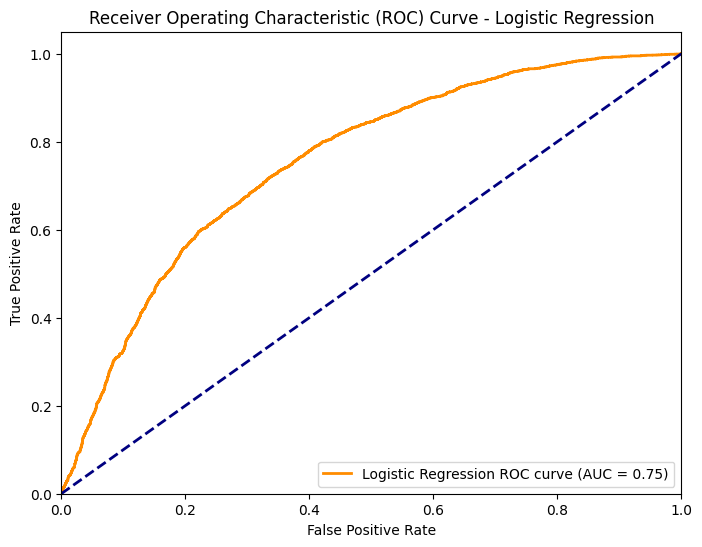

In [64]:
#compute ROC curve and AUC
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_logreg, tpr_logreg, color='darkorange', lw=2, label=f'Logistic Regression ROC curve (AUC = {roc_auc_logreg:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


## Random Forest

### Training Model

In [3]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Optional: If you decide to use SMOTE
USE_SMOTE = False  # Set to True if you want to apply SMOTE

def objective(trial):
    # Further refined hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 375, 385)          # Narrowed range around 380
    max_depth = trial.suggest_int('max_depth', 3, 5)                  # Focus around 4
    min_samples_split = trial.suggest_int('min_samples_split', 5, 6)  # Narrowed around 6
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 4)    # Slight flexibility
    max_features = 'log2'  # Fixed to 'log2' based on best trial
    class_weight = 'balanced_subsample'  # Fixed based on best trial
    criterion = 'entropy'  # Fixed based on best trial

    # Initialize the classifier with current trial's hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=True,  # Fixed to True based on previous refinement
        class_weight=class_weight,
        criterion=criterion,
        random_state=100,
        n_jobs=-1
    )
    
    # Create a pipeline
    pipeline = Pipeline([
        # Optional: Include StandardScaler if feature scaling is desired
        # Note: RandomForest is not sensitive to feature scaling, but included for completeness
        # ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    
    # Define cross-validation strategy with StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Optional: Apply SMOTE to handle class imbalance
    if USE_SMOTE:
        from imblearn.over_sampling import SMOTE  # Import here to avoid dependency if not used
        precision_scores = []
        for train_idx, valid_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
            
            smote = SMOTE(random_state=42)
            X_tr_res, y_tr_res = smote.fit_resample(X_tr, y_tr)
            
            pipeline.fit(X_tr_res, y_tr_res)
            y_pred = pipeline.predict(X_val)
            precision = precision_score(y_val, y_pred, zero_division=0)
            precision_scores.append(precision)
        
        precision = np.mean(precision_scores)
    else:
        # Evaluate using cross-validated precision without SMOTE
        precision = cross_val_score(
            pipeline, X_train, y_train,
            cv=cv,
            scoring='precision',
            n_jobs=-1
        ).mean()
    
    return precision

# Create a study object with MedianPruner for early stopping
pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=30)
study = optuna.create_study(direction='maximize', pruner=pruner)

# Optimize the objective function with the further refined search space
study.optimize(objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

# Get the best trial
best_trial = study.best_trial
best_params = best_trial.params
best_precision = best_trial.value

# Initialize the Random Forest classifier with best parameters
rf_best = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features='log2',  # Fixed based on best trial
    bootstrap=True,  # Manually set to True
    class_weight='balanced_subsample',  # Fixed based on best trial
    criterion='entropy',  # Manually set to 'entropy'
    random_state=100,
    n_jobs=-1
)

rf_best.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test)

# Calculate precision on the test set
test_precision = precision_score(y_test, y_pred, zero_division=0)

# Print the best parameters and best precision score from cross-validation
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated Precision Score: {best_precision:.4f}")

# Print the precision score on the test set
print(f"Test Precision Score: {test_precision:.4f}")


[I 2024-11-10 22:56:19,616] A new study created in memory with name: no-name-09793db3-5517-47bd-9311-dc71bd42f925
  0%|          | 0/200 [00:00<?, ?it/s]

[W 2024-11-10 22:56:19,623] Trial 0 failed with parameters: {'n_estimators': 381, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3} because of the following error: NameError("name 'X_train' is not defined").
Traceback (most recent call last):
  File "C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\aryan\AppData\Local\Temp\ipykernel_24380\87444775.py", line 67, in objective
    pipeline, X_train, y_train,
              ^^^^^^^
NameError: name 'X_train' is not defined
[W 2024-11-10 22:56:19,625] Trial 1 failed with parameters: {'n_estimators': 379, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4} because of the following error: NameError("name 'X_train' is not defined").
Traceback (most recent call last):
  File "C:\Users\aryan\AppData\L

NameError: name 'X_train' is not defined

### Training Evaluation

In [91]:
# make predictions on training set
y_train_pred_rf = rf_best.predict(X_train)

# calculate training evaluation metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
train_precision_rf = precision_score(y_train, y_train_pred_rf)
train_recall_rf = recall_score(y_train, y_train_pred_rf)
train_f1_rf = f1_score(y_train, y_train_pred_rf)

# display training metrics
print("Random Forest Training Performance Metrics:")
print(f"Accuracy : {train_accuracy_rf:.4f}")
print(f"Precision: {train_precision_rf:.4f}")
print(f"Recall   : {train_recall_rf:.4f}")
print(f"F1-Score : {train_f1_rf:.4f}")

Random Forest Training Performance Metrics:
Accuracy : 0.7168
Precision: 0.7686
Recall   : 0.6812
F1-Score : 0.7223


### Evaluation - Accuracy, Precision, Recall and F1-Score

In [92]:
# predict then evaluate
y_pred_rf = rf_best.predict(X_test)

# calc evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# display the metrics
print(f"Accuracy : {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall   : {recall_rf:.4f}")
print(f"F1-Score : {f1_rf:.4f}")

Accuracy : 0.7084
Precision: 0.7613
Recall   : 0.6711
F1-Score : 0.7134


### Confusion Matrix


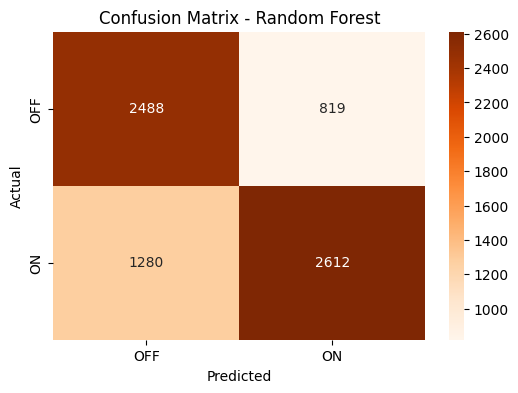

In [93]:
# gen  confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=['OFF', 'ON'], yticklabels=['OFF', 'ON'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest')
plt.show()

### Classification Reports

In [94]:
print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['OFF', 'ON']))

Classification Report - Random Forest:
              precision    recall  f1-score   support

         OFF       0.66      0.75      0.70      3307
          ON       0.76      0.67      0.71      3892

    accuracy                           0.71      7199
   macro avg       0.71      0.71      0.71      7199
weighted avg       0.71      0.71      0.71      7199



### ROC Curve

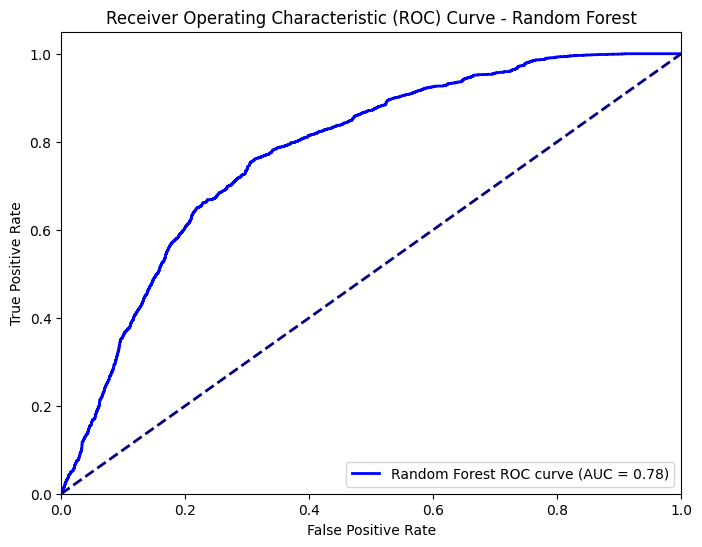

In [95]:
# Predict probabilities for ROC curve
y_prob_rf = rf_best.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

## Naive Bayes

### Training Model

In [75]:
# Import Necessary Libraries
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer
from scipy.stats import loguniform
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Assuming X_train, y_train, X_test, y_test are already defined
# Example:
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, random_state=42)
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline steps with optional PolynomialFeatures
pipeline = Pipeline([
    ('scaler', 'passthrough'),  # Placeholder, will be set in hyperparameter tuning
    ('pca', 'passthrough'),     # Placeholder, will be set in hyperparameter tuning
    ('poly', 'passthrough'),    # Placeholder for PolynomialFeatures
    ('gnb', GaussianNB())       # Placeholder, will be set in hyperparameter tuning
])

# Define the parameter distributions
param_dist = {
    # Feature scaling options
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    
    # PCA options: apply PCA with n_components from 1 to 4 or skip PCA
    'pca': [PCA(n_components=i, random_state=42) for i in range(1, 5)] + ['passthrough'],
    
    # Polynomial Features options: apply PolynomialFeatures with degree 2 or 3 or skip
    'poly': [PolynomialFeatures(degree=d, include_bias=False) for d in [2, 3]] + ['passthrough'],
    
    # GaussianNB hyperparameters
    'gnb__var_smoothing': loguniform(1e-12, 1e-6),
    
    # Optionally set priors (currently keeping it as None for simplicity)
    'gnb__priors': [None]
}

# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=100, shuffle=True, random_state=42)

# Define a custom precision scorer to handle cases where there might be no positive predictions
precision_scorer = make_scorer(precision_score, zero_division=0)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,             # Number of parameter settings sampled
    scoring=precision_scorer,  # Focus on precision
    cv=cv_strategy,
    verbose=1,
    random_state=42,
    n_jobs=-1               # Utilize all available CPU cores
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best parameters and best score from RandomizedSearchCV
best_params = random_search.best_params_
best_precision_cv = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated Precision Score: {best_precision_cv:.4f}")

# Extract the best model
gnb_best = random_search.best_estimator_

# Make predictions on the test set
y_pred_gnb = gnb_best.predict(X_test)

# Calculate precision on the test set for GaussianNB
test_precision_gnb = precision_score(y_test, y_pred_gnb, zero_division=0)

# Make predictions on the training set
y_train_pred_gnb = gnb_best.predict(X_train)

# Calculate training evaluation metrics
train_accuracy_gnb = accuracy_score(y_train, y_train_pred_gnb)
train_precision_gnb = precision_score(y_train, y_train_pred_gnb, zero_division=0)
train_recall_gnb = recall_score(y_train, y_train_pred_gnb, zero_division=0)
train_f1_gnb = f1_score(y_train, y_train_pred_gnb, zero_division=0)

# Display Training Metrics
print("\nGaussian Naive Bayes Training Performance Metrics:")
print(f"Accuracy : {train_accuracy_gnb:.4f}")
print(f"Precision: {train_precision_gnb:.4f}")
print(f"Recall   : {train_recall_gnb:.4f}")
print(f"F1-Score : {train_f1_gnb:.4f}")

# Display Test Metrics
print("\nGaussian Naive Bayes Test Performance Metrics:")
print(f"Precision: {test_precision_gnb:.4f}")

# Optional: Display Classification Report and Confusion Matrix for Test Set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_gnb, zero_division=0))

print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_gnb))


Fitting 100 folds for each of 100 candidates, totalling 10000 fits
Best Parameters: {'gnb__priors': None, 'gnb__var_smoothing': np.float64(4.903936725325051e-10), 'pca': 'passthrough', 'poly': PolynomialFeatures(include_bias=False), 'scaler': 'passthrough'}
Best Cross-Validated Precision Score: 0.7275

Gaussian Naive Bayes Training Performance Metrics:
Accuracy : 0.7030
Precision: 0.7273
Recall   : 0.7210
F1-Score : 0.7241

Gaussian Naive Bayes Test Performance Metrics:
Precision: 0.7210

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3307
           1       0.72      0.71      0.71      3892

    accuracy                           0.69      7199
   macro avg       0.69      0.69      0.69      7199
weighted avg       0.69      0.69      0.69      7199

Confusion Matrix (Test Set):
[[2241 1066]
 [1137 2755]]


### Training Evaluation


In [76]:
# make predictions on training set
y_train_pred_gnb = gnb_best.predict(X_train)

# calculate training evaluation metrics
train_accuracy_gnb = accuracy_score(y_train, y_train_pred_gnb)
train_precision_gnb = precision_score(y_train, y_train_pred_gnb)
train_recall_gnb = recall_score(y_train, y_train_pred_gnb)
train_f1_gnb = f1_score(y_train, y_train_pred_gnb)

# display training metrics
print("Gaussian Naive Bayes Training Performance Metrics:")
print(f"Accuracy : {train_accuracy_gnb:.4f}")
print(f"Precision: {train_precision_gnb:.4f}")
print(f"Recall   : {train_recall_gnb:.4f}")
print(f"F1-Score : {train_f1_gnb:.4f}")

Gaussian Naive Bayes Training Performance Metrics:
Accuracy : 0.7030
Precision: 0.7273
Recall   : 0.7210
F1-Score : 0.7241


### Evaluation - Accuracy, Precision, Recall, F1-Score

In [77]:
# predict using test set
y_pred_gnb = gnb_best.predict(X_test)
# predict probabilities for ROC curve
y_prob_gnb = gnb_best.predict_proba(X_test)[:, 1]

# calculate then display evaluation metrics
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
precision_gnb = precision_score(y_test, y_pred_gnb)
recall_gnb = recall_score(y_test, y_pred_gnb)
f1_gnb = f1_score(y_test, y_pred_gnb)
print("Gaussian Naive Bayes Performance Metrics:")
print(f"Accuracy : {accuracy_gnb:.4f}")
print(f"Precision: {precision_gnb:.4f}")
print(f"Recall   : {recall_gnb:.4f}")
print(f"F1-Score : {f1_gnb:.4f}")


Gaussian Naive Bayes Performance Metrics:
Accuracy : 0.6940
Precision: 0.7210
Recall   : 0.7079
F1-Score : 0.7144


### Confusion Matrix

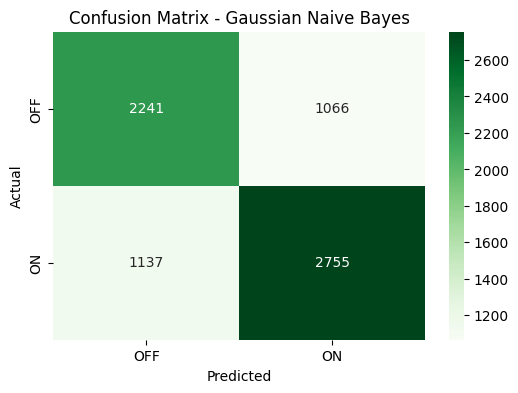

In [78]:
# Generate the confusion matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Greens', xticklabels=['OFF', 'ON'], yticklabels=['OFF', 'ON'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()


### Classification Report

In [ ]:
print("Classification Report - Gaussian Naive Bayes:")
print(classification_report(y_test, y_pred_gnb, target_names=['OFF', 'ON']))


Classification Report - Gaussian Naive Bayes:
              precision    recall  f1-score   support

         OFF       0.49      0.87      0.63      3307
          ON       0.68      0.24      0.36      3892

    accuracy                           0.53      7199
   macro avg       0.59      0.56      0.49      7199
weighted avg       0.60      0.53      0.48      7199



### ROC Curve

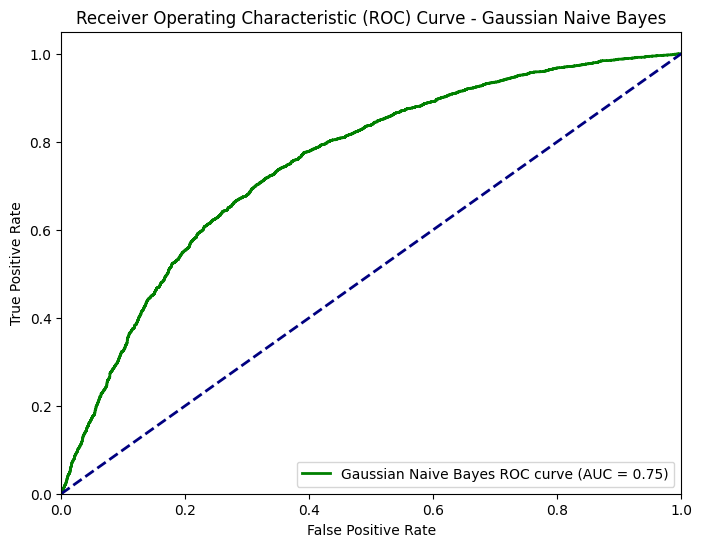

In [ ]:
# Compute ROC curve and AUC
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_prob_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_gnb, tpr_gnb, color='green', lw=2, label=f'Gaussian Naive Bayes ROC curve (AUC = {roc_auc_gnb:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()


# All Evaluation

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gnb, tpr_gnb, color='green', lw=2, label=f'Gaussian Naive Bayes (AUC = {roc_auc_gnb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


NameError: name 'fpr_logreg' is not defined

<Figure size 1000x800 with 0 Axes>